**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# FEM Analysis from Continuum Mechanics for the Case of Flow Boiling in a Verticle Steam Generator Tube
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Jack Kennedy and Nikolaus Kemper <br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Valmor F. de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**27Mar2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

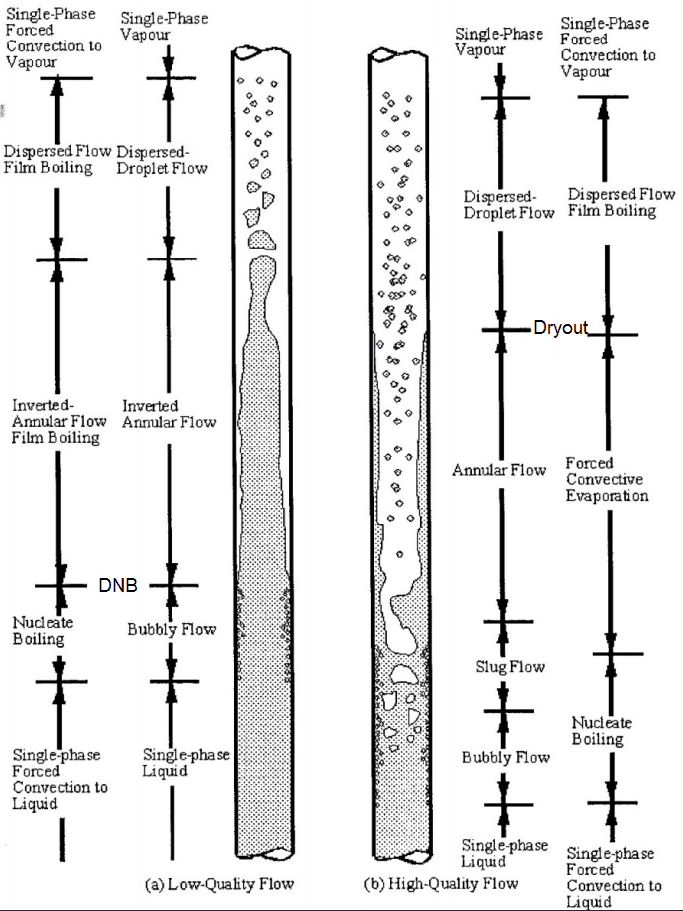

Steam generators are essential components of pressurized water reactors (PWRs) and comprise the most critical part of the nuclear steam supply system (NSSS). A steam generator consists of hundreds of tubes which absorb heat rejected by the core's coolant. This heat is made usefull by using it to generator steam, so that it can ultimately be used to generate work from inside a turbine. Water is pumped through each tube and if 

- Text... 

- Text... 

## [Problem Statement](#toc)<a id="problem"></a>

- Text... 

- Text... 

## [Objectives](#toc)<a id="obj"></a>

- Text...

- Text...

## [Approach](#toc)<a id="app"></a>

- Text...

- Text...

## [Results and Analysis](#toc)<a id="ranalysis"></a>

- Text...

- Text...

## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] J. Kennedy, N. Kemper, V. F. de Almeida, [Engy-4390: Small Modular Pressurized Water Reactor](https://github.com/dpploy/engy-4390/tree/main/projects/sm-pwr).
- [3] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [4] Nuclear Power for Everybody [(Nuclear-Power.net)](https://www.nuclear-power.net/nuclear-engineering/heat-transfer/boiling-and-condensation/flow-boiling-forced-convection-boiling/)
